In [1]:
import torch
import numpy as np

import random
import copy
import os
import pickle

import cl_gym as cl
from metrics import MetricCollector2, FairMetricCollector
from configs import make_params

EER_dataset = ["MNIST", "FashionMNIST", "CIFAR10", "CIFAR100"]

In [2]:
LOG_PATH = f"scripts_output"
OUT_PATH = f"outputs"

def is_number(value):
    flag=True
    try:
        num=float(value)
        flag = num == num
    except ValueError:
        flag=False
    return flag


def load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, fair_metric, randinx = False, verbose=2):
    # if dataset == "CIFAR10":
    #     dataset+="(prev)"
    path = f"dataset={dataset}"
    if randinx:
        path+="_randidx"
    # if method != "FSW":
    #     fair_metric = "no_metrics"
    path = os.path.join(path, method)
    path = os.path.join(path, fair_metric)

    # Get log_path
    runs = list()
    for d in os.listdir(os.path.join(LOG_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)
    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag
        if flag:
            avails.append(run)
    
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        return False
    target = avails[0]
    
    log_path = os.path.join(path, target['path'])

    out = os.path.join(os.path.join(LOG_PATH, log_path), "log.out")
    err = os.path.join(os.path.join(LOG_PATH, log_path), "log.err")
    if os.path.exists(err):
        with open(err, "r") as f:
            lines = f.readlines()
        if len(lines):
            if verbose:
                print(f"Error in {err} - error during running")
                for line in lines:
                    print(line)
            return False
    else:
        if verbose:
            print(f"error in {os.path.join(LOG_PATH, path)} - not exists")
        return False
    if os.path.exists(out):
        with open(out, "r") as f:
            lines = f.readlines()
        if len(lines) == 0:
            if verbose:
                print(f"{os.path.join(LOG_PATH, path)} - currently running")
            return False
        
    # Get out_path
    runs = list()
    for d in os.listdir(os.path.join(OUT_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)

    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag
        if flag:
            avails.append(run)
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        return False
    target = avails[0]
    out_path = os.path.join(path, target['path'])
    return out_path

def print_log(path, option='err'):
    out = os.path.join(os.path.join(LOG_PATH, path), "log.out")
    err = os.path.join(os.path.join(LOG_PATH, path), "log.err")    
    if option == "err":
        if os.path.exists(err):
            with open(out, "r") as f:
                lines = f.readlines()
                print(lines)
    elif option == "out":
        if os.path.exists(out):
            with open(out, "r") as f:
                lines = f.readlines()
                print(lines)

def load_metrics(path, verbose=0):
    metrics_dir = os.path.join(os.path.join(OUT_PATH, path), "metrics/metrics.pickle")
    try:
        with open(metrics_dir, "rb") as f:
            metric_manager_callback = pickle.load(f)
    except:
        print(f"{path} still running")
        return -1

    if verbose>0:
        print(f"{metric_manager_callback.meters.keys()}")
    return metric_manager_callback

In [3]:
def get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, \
             method, randinx = False, verbose=1, metric=None):
    randinx = False
    acc_list = list()
    fair_list = list()
    info_list = list()

    acc_data_list = list()
    fair_data_list = list()


    if dataset in EER_dataset:
        disp_metric = "EER"
        disp_metric2 = "EER"
        metric = "EER"
    else:
        if metric is None or metric == "no_metrics":
            disp_metric = "EO"
            disp_metric2 = "DP"
        else:
            if metric == "EO":
                disp_metric = "EO"
                disp_metric2 = "DP"
            elif metric == "DP":
                disp_metric = "DP"
                disp_metric2 = "EO"

    # MNIST
    # if method in ['joint', 'vanilla', 'finetune']:
    if method in ['joint', 'vanilla', 'finetune', 'AGEM', "GSS", "iCaRL", "WA", "OCS", "FaIRL"]:
        metric = "no_metrics"
    for tau in tau_range:
        for lr in lr_range:
            for alpha in alpha_range:
                for lmbd in lambda_range:
                    cnt = 0
                    acc_temp = list()
                    acc_std_temp = list()
                    fair_temp = list()
                    fair_2_temp = list()

                    acc_data_temp = list()
                    fair_data_temp = list()
                    fair_2_data_temp = list()
                    
                    fair_std_temp = list()
                    # print(f"{info=}")
                    avail_seed = copy.deepcopy(seed_range)
                    for seed in seed_range:
                        path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, randinx=randinx)
                        if not path:
                            if verbose>1:
                                print("Remove")
                                print(f"{dataset=}, {randinx=}, {method=}, {metric=}")
                                print(f"{seed=}, {epoch=}, {lr=}, {tau=}, {alpha=}, {lmbd=}")
                            avail_seed.remove(seed)
                            # print(seed)
                            # print(target_dir)
                            continue
                        mmc = load_metrics(path, verbose=verbose-1)
                        if mmc == -1:
                            continue
                        acc_temp.append(np.mean(mmc.meters['accuracy'].compute_overall()))
                        fair_temp.append(np.mean(mmc.meters[disp_metric].compute_overall()))
                        fair_2_temp.append(np.mean(mmc.meters[disp_metric2].compute_overall()))
                        acc_data_temp.append(mmc.meters['accuracy'].get_data())
                        fair_data_temp.append(mmc.meters[disp_metric].get_data())
                        fair_2_data_temp.append(mmc.meters[disp_metric2].get_data())
                        cnt+=1
                    info = f"lr={lr}_tau={tau}_alpha_{alpha}_lmbd_{lmbd}({cnt=}, {avail_seed})"
                    if cnt == 0:
                        print(f"{info=}: check if boom?")
                        continue
                    else:
                        acc_mean = np.mean(acc_temp)
                        acc_std = np.std(acc_temp)
                        fair_mean = np.mean(fair_temp)
                        fair_std = np.std(fair_temp)
                        fair_2_mean = np.mean(fair_2_temp)
                        fair_2_std = np.std(fair_2_temp)

                        acc_data_mean = np.round(np.mean(acc_data_temp, axis=0), 3)
                        fair_data_mean = np.round(np.mean(fair_data_temp, axis=0), 3)
                        fair_2_data_mean = np.round(np.mean(fair_2_data_temp, axis=0), 3)

                        acc_data_list.append(acc_data_mean)
                        fair_data_list.append(fair_data_mean)

                        info_list.append(info)
                        acc_list.append(acc_mean)
                        fair_list.append(fair_mean)
                        out = f"{info}\nacc:{acc_mean}±{acc_std}\nfair:{fair_mean}±{fair_std}"
                        if dataset not in EER_dataset:
                            out+=f"\nfair2:{fair_2_mean}±{fair_2_std}"
                        if verbose:
                            print(out)
    if verbose:
        print()

    # 대충 정한 measure
    # integrated_score = [e - 2*fair_list[i] for i, e in enumerate(acc_list)]
    # print(f"{acc_list=}")
    # idx = integrated_score.index(max(integrated_score))
    # print(f"{info_list[idx]}")
    # accuracy = acc_list[idx]
    # fairness = fair_list[idx]

    # if accuracy > 1:
    #     accuracy /= 100
    # print(f"acc:{accuracy}")
    # print(f"fair:{fairness}")
    return info_list, acc_list, fair_list, acc_data_list, fair_data_list


In [4]:
import matplotlib.pyplot as plt

def plot(acc_list, fair_list, marker = "o"):
    plt.scatter(acc_list, fair_list, marker=marker, s = 10)
    plt.xlabel('acc')
    plt.ylabel('fairness')

In [5]:
verbose = 1


dataset = "CIFAR10"
seed = 0
epoch = 50
lr = 0.01
tau = 1.0
alpha = 0.0
lmbd = 0.0
method = "vanilla"
metric = "no_metrics"

path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, randinx=False)
mmc = load_metrics(path, verbose=verbose-1)

lr=0.01_tau=0.5_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.5687936666666668±0.029422309419139012
fair:0.10248594444444444±0.01726515860216825
lr=0.01_tau=1.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.6046773333333333±0.005727072802827708
fair:0.07664031111111111±0.006009571452603799
lr=0.01_tau=1.5_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.6298553333333332±0.008443222883867667
fair:0.08141532222222223±0.007291060799413265
lr=0.01_tau=2.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.6145349999999998±0.016326903666443713
fair:0.09705859999999998±0.00946988174586888
lr=0.01_tau=2.5_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.6079589999999999±0.014052396142058285
fair:0.10438940000000001±0.014456613284660486
lr=0.01_tau=3.0_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.6048263333333334±0.02237714477367971
fair:0.09482607777777778±0.017674793322891038
lr=0.01_tau=3.5_alpha_0.0_lmbd_0.0(cnt=5, [0, 1, 2, 3, 4])
acc:0.5696063333333333±0.035473845582970585
fair:0

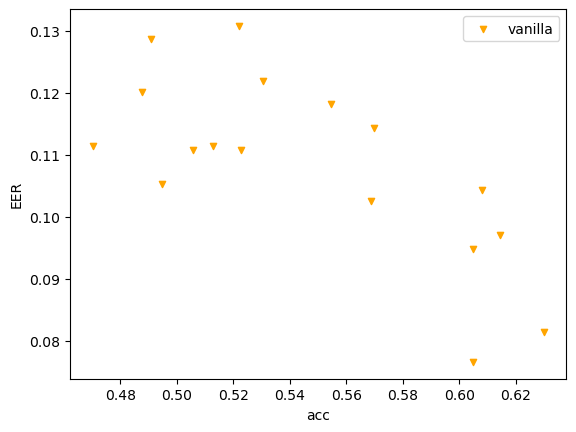

In [11]:
# DEMO

dataset = "CIFAR10"
seed_range = [0, 1, 2, 3, 4]
# seed_range = [0, 1, 2, 4]
# seed_range = [0]
epoch = 50
lr_range = [0.01]
tau_range = [1.0, 2.0, 3.0]
# tau_range = [1.0, 2.0]
# alpha_range = [0.005]
# lambda_range = [0.1, 0.5, 1.0, 2.0]
metric="EER"
# # metric="DP"
# method = "FSW"

# base_info_list, base_acc_list, base_fair_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric, verbose=1)
# plt.scatter(base_acc_list, base_fair_list, marker='v', s = 20, label=method)
tau_range = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0, 9.0, 10.0]
lambda_range = [0.0]
alpha_range = [0.0]

method="vanilla"
base_info_list, base_acc_list, base_fair_list, acc_data_list, fair_data_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric, verbose=1)
plt.scatter(base_acc_list, base_fair_list, marker='v', s = 20, c ="orange" , label=method)


plt.xlabel('acc')
plt.ylabel('EER')

plt.legend()


In [14]:
for i, e in enumerate(acc_data_list):
    print(f"tau = {tau_range[i]}")
    print(e)

tau = 0.5
[[0.977 0.    0.    0.    0.   ]
 [0.578 0.576 0.    0.    0.   ]
 [0.482 0.348 0.549 0.    0.   ]
 [0.574 0.236 0.399 0.64  0.   ]
 [0.312 0.178 0.292 0.406 0.65 ]]
tau = 1.0
[[0.977 0.    0.    0.    0.   ]
 [0.642 0.614 0.    0.    0.   ]
 [0.608 0.493 0.386 0.    0.   ]
 [0.601 0.304 0.466 0.562 0.   ]
 [0.425 0.199 0.421 0.512 0.638]]
tau = 1.5
[[0.977 0.    0.    0.    0.   ]
 [0.666 0.634 0.    0.    0.   ]
 [0.668 0.557 0.331 0.    0.   ]
 [0.662 0.33  0.496 0.625 0.   ]
 [0.433 0.274 0.417 0.576 0.677]]
tau = 2.0
[[0.977 0.    0.    0.    0.   ]
 [0.665 0.542 0.    0.    0.   ]
 [0.686 0.566 0.282 0.    0.   ]
 [0.67  0.333 0.504 0.558 0.   ]
 [0.424 0.252 0.366 0.566 0.712]]
tau = 2.5
[[0.977 0.    0.    0.    0.   ]
 [0.745 0.439 0.    0.    0.   ]
 [0.656 0.521 0.317 0.    0.   ]
 [0.689 0.325 0.504 0.572 0.   ]
 [0.443 0.254 0.394 0.562 0.596]]
tau = 3.0
[[0.977 0.    0.    0.    0.   ]
 [0.701 0.507 0.    0.    0.   ]
 [0.682 0.505 0.3   0.    0.   ]
 [0.681 0.2

lr=0.01_tau=1.0_alpha_0.005_lmbd_0.1(cnt=3, [0, 1, 2])
acc:0.4605555555555556±0.008168452450256297
fair:0.12995759259259257±0.017122770792539824
lr=0.01_tau=1.0_alpha_0.005_lmbd_0.5(cnt=3, [0, 1, 2])
acc:0.4772433333333333±0.012259003720621924
fair:0.10172894444444443±0.012947846436834646
lr=0.01_tau=1.0_alpha_0.005_lmbd_1.0(cnt=3, [0, 1, 2])
acc:0.48690944444444445±0.019033036694192273
fair:0.10265951851851851±0.030858087865562777
lr=0.01_tau=1.0_alpha_0.005_lmbd_2.0(cnt=3, [0, 1, 2])
acc:0.46605222222222226±0.019676496146857115
fair:0.10217911111111111±0.010493056089565406
lr=0.01_tau=2.0_alpha_0.005_lmbd_0.1(cnt=3, [0, 1, 2])
acc:0.4713766666666667±0.01007656365956097
fair:0.1295695±0.0046446502774254595
lr=0.01_tau=2.0_alpha_0.005_lmbd_0.5(cnt=3, [0, 1, 2])
acc:0.4841061111111111±0.019033122996178358
fair:0.15253324074074073±0.008172379892772778
lr=0.01_tau=2.0_alpha_0.005_lmbd_1.0(cnt=3, [0, 1, 2])
acc:0.4886327777777777±0.023297868537594985
fair:0.11973203703703701±0.018835489395

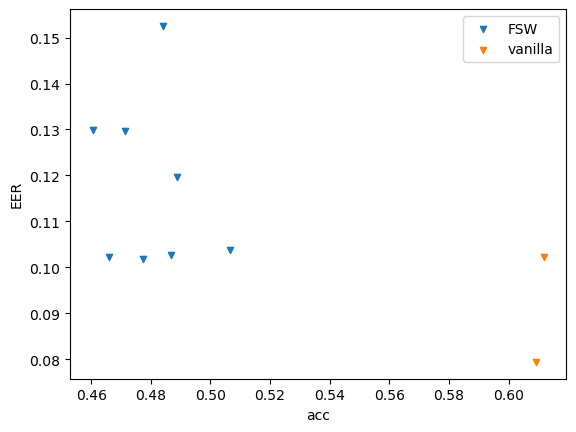

In [9]:
# DEMO

dataset = "CIFAR10"
seed_range = [0, 1, 2, 3, 4]
seed_range = [0, 1, 2]
# seed_range = [0]
epoch = 50
lr_range = [0.01]
tau_range = [1.0, 2.0, 3.0]
tau_range = [1.0, 2.0]
alpha_range = [0.005]
lambda_range = [0.1, 0.5, 1.0, 2.0]
metric="EER"
# metric="DP"
method = "FSW"

base_info_list, base_acc_list, base_fair_list, acc_data_list, fair_data_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric, verbose=1)
plt.scatter(base_acc_list, base_fair_list, marker='v', s = 20, label=method)

lambda_range = [0.0]
alpha_range = [0.0]

method="vanilla"
base_info_list, base_acc_list, base_fair_list, acc_data_list, fair_data_list = get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, method, metric=metric, verbose=1)
plt.scatter(base_acc_list, base_fair_list, marker='v', s = 20, label=method)


plt.xlabel('acc')
plt.ylabel('EER')

plt.legend()


In [81]:
seed = 0

num_task = 5
per_task_classes = 2
verbose = 2
dataset = "CIFAR10"
epoch = 50
lr = 0.01
tau = 2.0
alpha = 0.0
lmbd = 0.0
method = "vanilla"
metric = "no_metrics"

vanilla_path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, randinx=False)
vanilla_mmc = load_metrics(vanilla_path, verbose=verbose-1)

verbose = 2
dataset = "CIFAR10"
epoch = 50
lr = 0.01
tau = 2.0
alpha = 0.005
lmbd = 0.1
method = "FSW"
metric = "EER"

FSW_path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, randinx=False)
FSW_mmc = load_metrics(FSW_path, verbose=verbose-1)


dict_keys(['accuracy', 'EER', 'std', 'forgetting', 'loss'])
dict_keys(['accuracy', 'EER', 'std', 'forgetting', 'loss'])


In [82]:
vanilla_acc_array = np.zeros(epoch*num_task)
vanilla_eer_array = np.zeros(epoch*num_task)
for k in range(epoch):
    mean_data = vanilla_mmc.meters['EER'].acc_metric.data[1:,1:,k]
    for i, e in enumerate(mean_data):
        task_mean = np.mean(e[:i+1])
        abs_diff = list()
        for j in range(i+1):
            abs_diff.append(np.abs(mean_data[i, j] - task_mean))
        task_eer = np.mean(abs_diff)
        vanilla_acc_array[i*epoch+k] = task_mean
        vanilla_eer_array[i*epoch+k] = task_eer
        # print(task_mean)


In [83]:
FSW_acc_array = np.zeros(epoch*num_task)
FSW_eer_array = np.zeros(epoch*num_task)
for k in range(epoch):
    eer_data = FSW_mmc.meters['EER'].data[1:,1:,k]
    mean_data = FSW_mmc.meters['EER'].acc_metric.data[1:,1:,k]
    for i, e in enumerate(mean_data):
        task_mean = np.mean(e[:i+1])
        abs_diff = list()
        for j in range(i+1):
            abs_diff.append(np.abs(mean_data[i, j] - task_mean))
        task_eer = np.mean(abs_diff)
        FSW_acc_array[i*epoch+k] = task_mean
        FSW_eer_array[i*epoch+k] = task_eer
        # print(task_mean)


In [84]:
vanilla_mmc.meters['EER'].acc_metric.data[1:,1:,-1]

array([[0.982 , 0.    , 0.    , 0.    , 0.    ],
       [0.7155, 0.6295, 0.    , 0.    , 0.    ],
       [0.68  , 0.527 , 0.4815, 0.    , 0.    ],
       [0.7165, 0.47  , 0.4335, 0.5765, 0.    ],
       [0.495 , 0.2805, 0.4335, 0.619 , 0.63  ]])

In [85]:
FSW_mmc.meters['EER'].acc_metric.data[1:,1:,-1]

array([[0.974 , 0.    , 0.    , 0.    , 0.    ],
       [0.647 , 0.7205, 0.    , 0.    , 0.    ],
       [0.7025, 0.502 , 0.3725, 0.    , 0.    ],
       [0.769 , 0.366 , 0.484 , 0.6205, 0.    ],
       [0.479 , 0.3705, 0.382 , 0.6535, 0.633 ]])

In [40]:
for k in range(epoch):
    eer_data = FSW_mmc.meters['EER'].data[1:,1:,k]
    mean_data = FSW_mmc.meters['EER'].acc_metric.data[1:,1:,k]
    for i, e in enumerate(mean_data):
        if i != 2:
            continue
        print(e)
        # task_mean = np.mean(e[:i+1])
        # abs_diff = list()
        # for j in range(i+1):
        #     abs_diff.append(np.abs(mean_data[i, j] - task_mean))
        # task_eer = np.mean(abs_diff)
        # FSW_acc_array[i*epoch+k] = task_mean
        # FSW_eer_array[i*epoch+k] = task_eer


[0.4475 0.389  0.259  0.     0.    ]
[0.5915 0.5805 0.087  0.     0.    ]
[0.5925 0.5525 0.095  0.     0.    ]
[0.5225 0.613  0.119  0.     0.    ]
[0.579  0.5225 0.0705 0.     0.    ]
[0.529  0.4735 0.13   0.     0.    ]
[0.616  0.5895 0.0945 0.     0.    ]
[0.6095 0.543  0.052  0.     0.    ]
[0.621  0.5675 0.111  0.     0.    ]
[0.54  0.606 0.126 0.    0.   ]
[0.611  0.5695 0.142  0.     0.    ]
[0.606  0.594  0.1245 0.     0.    ]
[0.6375 0.5655 0.1265 0.     0.    ]
[0.634  0.453  0.2775 0.     0.    ]
[0.625  0.564  0.2105 0.     0.    ]
[0.652 0.569 0.091 0.    0.   ]
[0.589  0.5395 0.229  0.     0.    ]
[0.618 0.577 0.203 0.    0.   ]
[0.6385 0.59   0.159  0.     0.    ]
[0.5875 0.5735 0.213  0.     0.    ]
[0.6245 0.575  0.2055 0.     0.    ]
[0.607  0.601  0.1815 0.     0.    ]
[0.5595 0.5235 0.2505 0.     0.    ]
[0.5635 0.5455 0.262  0.     0.    ]
[0.614 0.569 0.216 0.    0.   ]
[0.5695 0.5835 0.242  0.     0.    ]
[0.6075 0.5175 0.2555 0.     0.    ]
[0.597  0.5955 0.1885

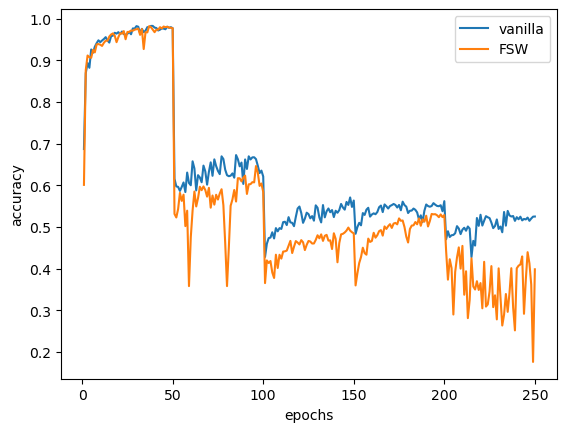

In [41]:
x = np.arange(1, epoch*num_task+1)

plt.plot(x, vanilla_acc_array, label = "vanilla")
plt.plot(x, FSW_acc_array, label = "FSW")

plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

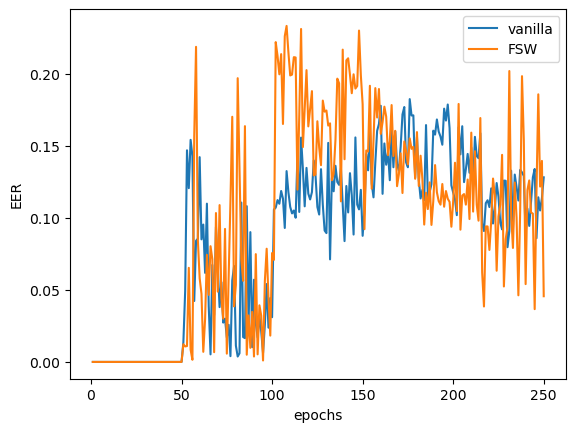

In [42]:
x = np.arange(1, epoch*num_task+1)

plt.plot(x, vanilla_eer_array, label = "vanilla")
plt.plot(x, FSW_eer_array, label = "FSW")

plt.legend()
plt.xlabel('epochs')
plt.ylabel('EER')

plt.show()

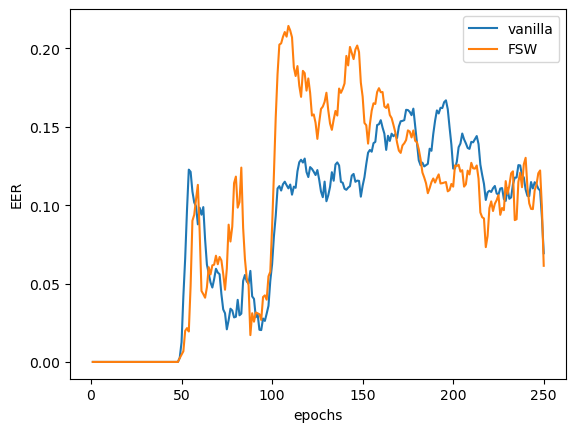

In [43]:
moving_average_frame = 5
mrf = moving_average_frame

x = np.arange(1, epoch*num_task+1)

plt.plot(x, np.convolve(vanilla_eer_array, np.ones(mrf), "same")/mrf, label = "vanilla")
plt.plot(x, np.convolve(FSW_eer_array, np.ones(mrf), "same")/mrf, label = "FSW")

plt.legend()
plt.xlabel('epochs')
plt.ylabel('EER')

plt.show()



In [44]:
np.mean(FSW_eer_array)

0.09712195444444444

In [45]:
np.mean(vanilla_eer_array)

0.08679261222222223